In [14]:
%matplotlib inline 
import CRISPR_dCas9_binding_curve_Boyle as Boyle
reload(Boyle)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import seaborn as sns 
sns.set_style('ticks');
current_color = sns.color_palette();
sns.set_palette('Set2');

#import plotsettings 
#publishable = plotsettings.Set('Cell') 

# Adjust all text and axes colors to black. default is some studip gray that appears to faint when printed 
from matplotlib import rc , rcParams
rc('axes',edgecolor='black')
rc('xtick',color='black',labelsize=15)
rc('ytick',color='black',labelsize=15)
rc('text',color='black')
rc('axes',labelcolor='black',linewidth=2.0)
rc('font',size=15)
rcParams["patch.force_edgecolor"] = True

In [4]:
Path = '../Data_Boyle/KoenDataForMisha/3ModelFit/'
OT_landscape = np.loadtxt(delimiter=',', fname=Path+'3ModelOTLandscape.txt')
epsilon_C = np.diff(OT_landscape)
epsilon_I = np.loadtxt(delimiter=',', fname=Path+'3ModelMismatches.txt')-epsilon_C[1:]
rates = np.loadtxt(delimiter='\n', fname=Path+'3ModelRates.txt')
epsilon = np.append(epsilon_C, epsilon_I)
parameters = np.append(epsilon, rates)

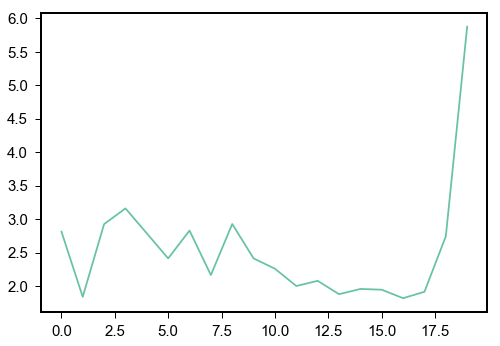

In [5]:
plt.plot(range(0,20), epsilon_I)
plt.show()

## Check unpack_parameters

In [95]:
new_epsilon, forward_rates = Boyle.unpack_parameters(parameters=parameters)
check = np.sum(epsilon-new_epsilon)==0
if check:
    print 'epsilon is rigth'
print forward_rates
print len(forward_rates)

epsilon is rigth
[ 0.10658859  2.48989913  2.48989913  2.48989913  2.48989913  2.48989913
  2.48989913  2.48989913  2.48989913  2.48989913  2.48989913  2.48989913
  2.48989913  2.48989913  2.48989913  2.48989913  2.48989913  2.48989913
  2.48989913  2.48989913  2.48989913  0.        ]
22


## Check get_energies

In [96]:
mismatch_positions = []
OT_energies = Boyle.get_energies(epsilon,mismatch_positions)
check = np.sum(OT_energies-epsilon_C)==0
if check:
    print 'OT energy correct'
mismatch_positions = [1,5]
energies = Boyle.get_energies(epsilon,mismatch_positions)
checkenergies = OT_energies.copy()
checkenergies[1] = checkenergies[1]+epsilon_I[0]
checkenergies[5] = checkenergies[5]+epsilon_I[4]
print 'difference between OF and OT energies:'
print (checkenergies-OT_energies)
check = np.sum(checkenergies-energies)==0
if check:
    print 'OF energy correct'

OT energy correct
difference between OF and OT energies:
[ 0.          2.81457747  0.          0.          0.          2.78633019
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.        ]
OF energy correct


## Check get_backward_rates

In [97]:
backward_rates = Boyle.get_backward_rates(energies, forward_rates)
print backward_rates
print len(backward_rates)

[  0.          95.8216772   32.75431014   2.43192143   2.46512421
   2.43151006  39.05730939   2.464641     2.45012216   2.46512422
   2.46512422   2.46462941   2.46026469   2.39681254   0.79875474
   0.44805622   2.43697674   0.39175154   0.41779923   0.40070166
   2.43095688   0.30564096]
22


## Check build_rate_matrix and get_master_equation

In [98]:
rate_matrix = Boyle.build_rate_matrix(backward_rates=backward_rates, 
                                      forward_rates=forward_rates)
rate_matrix_2 = Boyle.get_master_equation(parameters=parameters, mismatch_positions=mismatch_positions, model_id='general_energies', guide_length=20)

check = np.sum(rate_matrix-rate_matrix_2)==0

if check:
    print 'build_rate_matrix calculates the same as get_master_equation' 

build_rate_matrix calculates the same as get_master_equation


In [109]:
Boyle.calc_Boyle(True, True, True,
               parameters, mismatch_positions=[17,18])

(0.69192772408636793, 0.00022211548444814869, 0.00011032854992262117)

## Calculate kon, koff, and Pbound
NOTE: For this section I have temporarily changed the mane code to set the equilibration time to 12000 hours instead of 12 hours :-). This makes it comparable to Koens prediction 

In [29]:

on_rate = np.loadtxt(delimiter=',', fname=Path+'3ModelOnRate.txt')
off_rate = np.loadtxt(delimiter=',', fname=Path+'3ModelOffRate.txt')
Pbound = np.loadtxt(delimiter=',', fname=Path+'3ModelOccupancy.txt')

on_rate_predict = np.zeros([20,20])
off_rate_predict = np.zeros([20,20])
Pbound_predict = np.zeros([20,20])

Pbound_OT,_,_ = Boyle.calc_Boyle(True, True, True,parameters, [])

for i in range(0,20):
    for j in range(0,20):
        mismatch_positions = [20-i, 20-j]
        if i==j:
            mismatch_positions = [20-i]
        predictions = Boyle.calc_Boyle(True, True, True,parameters, mismatch_positions)
        Pbound_predict[i,j] = predictions[0]/Pbound_OT
        on_rate_predict[i,j] = predictions[1]
        off_rate_predict[i,j] = predictions[2]
        


In [18]:
print 'difference in kon:'
print np.sum(np.abs(on_rate_predict-on_rate))

print 'difference in koff:'
print np.sum(np.abs(off_rate_predict-off_rate))

print 'difference in pbound:'
print np.sum(np.abs(Pbound_predict-Pbound))


difference in kon:
4.21455365487e-13
difference in koff:
1.67934550374e-13
difference in pbound:
6.52159173101e-05


'\ncolorbar\n'

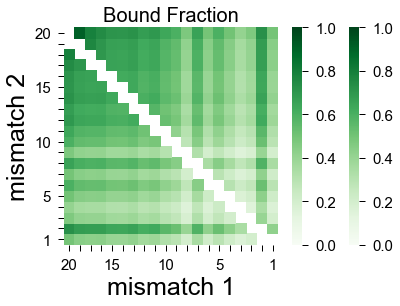

In [19]:
B = Pbound

mask = np.zeros(shape=B.shape)
for i in range(len(B)):
    for j in range(i-1,len(B)):
        mask[i,j] = 1
        
axHeatmap=sns.heatmap(B, cmap='Greens',mask=mask,cbar=True,vmin=0,vmax=1);
        
    
model = Pbound_predict

mask = np.ones(shape=model.shape)
for i in range(len(B)):
    for j in range(i+1,len(B)):
        mask[i,j] = 0
sns.heatmap(model, cmap='Greens',mask=mask,cbar=True,vmin=0,vmax=1);


plt.xticks([i+0.5 for i in range(20)], 
           [20,'','','',15,'','','','',10,'','','','',5,'','','','',1], rotation=0);

plt.yticks([i+0.5 for i in range(20)], 
           [1,'','','',5,'','','','',10,'','','','',15,'','','','',20], rotation=0);

plt.xlabel('mismatch 1',fontsize=25);
plt.ylabel('mismatch 2',fontsize=25);
plt.title('Bound Fraction',fontsize=20);





'''
colorbar
'''
# cbar = axHeatmap.figure.colorbar(axHeatmap.axes.collections[0],aspect=15);
# cbar.set_label(r'$\mu M^{-1} s^{-1}$',rotation=-90, labelpad=-100,fontsize=15,y=0.5,color='black')
# cbar.set_ticks([4,5*10**(-5),5*10**(-5),5*10**(-5),5*10**(-5)]);
# cbar.ax.set_yticklabels([0,'',0.5,'',1],fontsize=15);


# plt.savefig('occupancy_generalmodel_globalfit_v2.pdf',format='pdf',bbox_inches='tight');
# plt.savefig('occupancy_simplified_landscape.pdf',format='pdf',bbox_inches='tight');
# plt.savefig('occupancy_overfit_bad_fit.pdf',format='pdf',bbox_inches='tight');
# plt.savefig('occupancy_underfit.pdf',format='pdf',bbox_inches='tight');

'\ncolorbar\n'

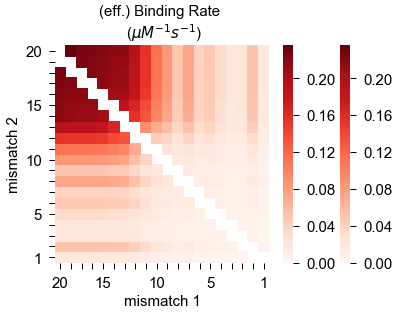

In [30]:
B =on_rate
B *= 10**3
mask = np.zeros(shape=B.shape)
for i in range(len(B)):
    for j in range(i-1,len(B)):
        mask[i,j] = 1
        
axHeatmap=sns.heatmap(B, cmap='Reds',mask=mask,cbar=True,vmin=0);
        
    
model = on_rate_predict
model  *=10**3
mask = np.ones(shape=model.shape)
for i in range(len(model)):
    for j in range(i+1,len(model)):
        mask[i,j] = 0
sns.heatmap(model, cmap='Reds',mask=mask,cbar=True,vmin=0);


plt.xticks([i+0.5 for i in range(20)], 
           [20,'','','',15,'','','','',10,'','','','',5,'','','','',1], rotation=0);

plt.yticks([i+0.5 for i in range(20)], 
           [1,'','','',5,'','','','',10,'','','','',15,'','','','',20], rotation=0);

plt.xlabel('mismatch 1',fontsize=15);
plt.ylabel('mismatch 2',fontsize=15);
plt.title('(eff.) Binding Rate \n ($ \mu M^{-1} s^{-1}$)',fontsize=15);





'''
colorbar
'''
# cbar = axHeatmap.figure.colorbar(axHeatmap.axes.collections[0],aspect=15);
# cbar.set_label(r'$\mu M^{-1} s^{-1}$',rotation=-90, labelpad=-100,fontsize=15,y=0.5,color='black')
# cbar.set_ticks([4,5*10**(-5),5*10**(-5),5*10**(-5),5*10**(-5)]);
# cbar.ax.set_yticklabels([0,'',0.5,'',1],fontsize=15);


# plt.savefig('association_generalmodel_globalfit.pdf',format='pdf',bbox_inches='tight')
# plt.savefig('association_simplified_landscape.pdf',format='pdf',bbox_inches='tight');


'\ncolorbar\n'

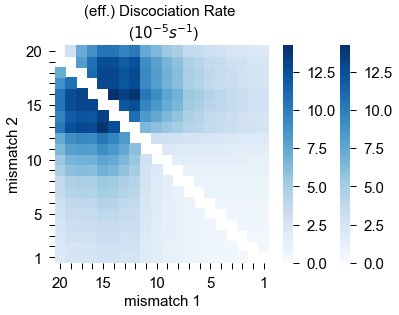

In [32]:
B = off_rate
B *= 10**5
mask = np.zeros(shape=B.shape)
for i in range(len(B)):
    for j in range(i-1,len(B)):
        mask[i,j] = 1
        
axHeatmap=sns.heatmap(B, cmap='Blues',mask=mask,cbar=True,vmin=0);
        
    
model = off_rate_predict        
model  *=10**5
mask = np.ones(shape=model.shape)
for i in range(len(model)):
    for j in range(i+1,len(model)):
        mask[i,j] = 0
sns.heatmap(model, cmap='Blues',mask=mask,cbar=True,vmin=0);


plt.xticks([i+0.5 for i in range(20)], 
           [20,'','','',15,'','','','',10,'','','','',5,'','','','',1], rotation=0);

plt.yticks([i+0.5 for i in range(20)], 
           [1,'','','',5,'','','','',10,'','','','',15,'','','','',20], rotation=0);

plt.xlabel('mismatch 1',fontsize=15);
plt.ylabel('mismatch 2',fontsize=15);
plt.title('(eff.) Discociation Rate \n ($ 10^{-5} s^{-1}$)',fontsize=15);





'''
colorbar
'''
#cbar = axHeatmap.figure.colorbar(axHeatmap.axes.collections[0],aspect=15);
# cbar.set_label(r'$\mu M^{-1} s^{-1}$',rotation=-90, labelpad=-100,fontsize=15,y=0.5,color='black')
# cbar.set_ticks([4,5*10**(-5),5*10**(-5),5*10**(-5),5*10**(-5)]);
# cbar.ax.set_yticklabels([0,'',0.5,'',1],fontsize=15);

# plt.savefig('dissociation_simplified_landscape.pdf',format='pdf',bbox_inches='tight');
#plt.savefig('dissociation_underfit.pdf',format='pdf',bbox_inches='tight');

### Now we set T=12 h and also scle the real on rate by a factor of 0.1

In [95]:
reload(Boyle);
on_rate = np.loadtxt(delimiter=',', fname=Path+'3ModelOnRate.txt')
off_rate = np.loadtxt(delimiter=',', fname=Path+'3ModelOffRate.txt')
Pbound = np.loadtxt(delimiter=',', fname=Path+'3ModelOccupancy.txt')

on_rate_predict = np.zeros([20,20])
off_rate_predict = np.zeros([20,20])
Pbound_predict = np.zeros([20,20])

Pbound_OT,_,_ = Boyle.calc_Boyle(True, True, True,parameters, [])

for i in range(0,20):
    for j in range(0,20):
        mismatch_positions = [20-i, 20-j]
        if i==j:
            mismatch_positions = [20-i]
        predictions = Boyle.calc_Boyle(True, True, True,parameters, mismatch_positions)
        Pbound_predict[i,j] = predictions[0]/Pbound_OT
        on_rate_predict[i,j] = predictions[1]
        off_rate_predict[i,j] = predictions[2]
        


'\ncolorbar\n'

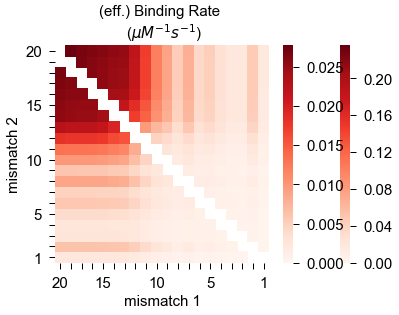

In [40]:
B =on_rate
B *= 10**3
mask = np.zeros(shape=B.shape)
for i in range(len(B)):
    for j in range(i-1,len(B)):
        mask[i,j] = 1
        
axHeatmap=sns.heatmap(B, cmap='Reds',mask=mask,cbar=True,vmin=0);
        
    
model = on_rate_predict
model  *=10**3
mask = np.ones(shape=model.shape)
for i in range(len(model)):
    for j in range(i+1,len(model)):
        mask[i,j] = 0
sns.heatmap(model, cmap='Reds',mask=mask,cbar=True,vmin=0);


plt.xticks([i+0.5 for i in range(20)], 
           [20,'','','',15,'','','','',10,'','','','',5,'','','','',1], rotation=0);

plt.yticks([i+0.5 for i in range(20)], 
           [1,'','','',5,'','','','',10,'','','','',15,'','','','',20], rotation=0);

plt.xlabel('mismatch 1',fontsize=15);
plt.ylabel('mismatch 2',fontsize=15);
plt.title('(eff.) Binding Rate \n ($ \mu M^{-1} s^{-1}$)',fontsize=15);





'''
colorbar
'''
# cbar = axHeatmap.figure.colorbar(axHeatmap.axes.collections[0],aspect=15);
# cbar.set_label(r'$\mu M^{-1} s^{-1}$',rotation=-90, labelpad=-100,fontsize=15,y=0.5,color='black')
# cbar.set_ticks([4,5*10**(-5),5*10**(-5),5*10**(-5),5*10**(-5)]);
# cbar.ax.set_yticklabels([0,'',0.5,'',1],fontsize=15);


# plt.savefig('association_generalmodel_globalfit.pdf',format='pdf',bbox_inches='tight')
# plt.savefig('association_simplified_landscape.pdf',format='pdf',bbox_inches='tight');


### Check calc_Chi_square 

In [130]:
reload(Boyle)
import Boyle_data_processing as Bdata
reload(Bdata)

<module 'Boyle_data_processing' from 'Boyle_data_processing.pyc'>

In [60]:
xdata_all, ydata_all = Bdata.prepare_multiprocessing()

In [96]:
xdata = xdata_all[0]
ydata = ydata_all[0]
yerr = []
ONtarget_occupancy = Pbound_OT
Boyle.calc_Chi_square(parameters,xdata,ydata,yerr,
                    ONtarget_occupancy)

0.077196208191895113

In [102]:
[occ, on, off] = Boyle.calc_Boyle(True, True, True,parameters, xdata)

ydata = (np.array([occ/ONtarget_occupancy]*3), np.array([on]), np.array([off]*2))
print Boyle.calc_Chi_square(parameters,xdata,ydata,yerr,
                    ONtarget_occupancy)

ydata = (np.array([occ/ONtarget_occupancy]*3), np.array([]), np.array([off]*2))
print Boyle.calc_Chi_square(parameters,xdata,ydata,yerr,
                    ONtarget_occupancy)

ydata = (np.array([occ/ONtarget_occupancy]*3), np.array([on]), np.array([]))
print Boyle.calc_Chi_square(parameters,xdata,ydata,yerr,
                    ONtarget_occupancy)

0.0
0.0
0.0


### Check weights_averages

In [129]:
Bdata.weights_averages()

array([  2.45209549e+00,   1.29538499e+08,   4.45983372e+08])

### Python class example

In [106]:
class Dog():
    
    def __init__(self, age, name,trick):
        self.age = age
        self.name = name
        self.trick=trick
    
    def bark(self):
        print "woef!"
    def what_is_your_name(self):
        for letter in self.name:
            print letter + '...'
    
        
        
Bingo = Dog(name='Bingo',age=2,trick=np.sqrt)
Bingo.bark()
Bingo.name
Bingo.what_is_your_name()

woef!
B...
i...
n...
g...
o...
